# Neural Networks Course - LEONARDO H. DE MORAES - Final Project  

**Name:** Leonardo H. de Moraes  
**Student ID:** 1711609  

**Course:** Neural Networks - Polytechnic Institute of Guarda (IPG)  
**Acronym:** LEI  
**Department:** School of Technology and Management  
**Degree:** Bachelor's  
**Program:** Computer Engineering  
**Academic Year:** 2024/2025  
**Professor:** Noel de Jesus Mendonça Lopes  

---

## Project Objective  
The goal of this project is to develop predictive models for the exchange rates of the US Dollar (**USD**) and the Japanese Yen (**JPY**) against the Euro (**EUR**). Students will use neural networks to build and compare different models.  

In [1]:
## == Import Libs
import pandas as pd
import numpy as np
import requests
import dotenv
import os
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
from dataset_utils.extrac_transf_data import *
## == Import libs 


## == Set global variables
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = '2015-01-01'

In [2]:
print('+ == =================================================================== == +')
print('|                           Starting extract data!                          |')
print('+ == =================================================================== == +')

df_final = build_complete_dataset(start_date, end_date)

+ == =================================================================== == +
|                           Starting extract data!                          |
+ == =================================================================== == +
    ↳ Obtendo dados de câmbio USD/EUR de 2015-01-01 a 2025-05-26...
    ↳ Obtendo dados de câmbio JPY/EUR de 2015-01-01 a 2025-05-26...
    ↳ Obtendo dados de preço do petróleo de 2015-01-01 a 2025-05-26...
    ↳ Obtendo dados de taxas de juros de 2015-01-01 a 2025-05-26...
    ↳ Obtendo dados do S&P 500 de 2015-01-01 a 2025-05-26...


In [3]:
print('+ == =================================================================== == +')
print('|                           Load and plot data!                             |')
print('+ == =================================================================== == +')

# Verificar o resultado
print("\n   ↳ Dataset construído com sucesso!")
print(f"    ↳ Colunas disponíveis: {df_final.columns.tolist()}")
print(f"    ↳ Número de observações: {len(df_final)}")


# Salvar o dataset
output_file = f"../data/dateset/multi_forex_dataset_{start_date}_to_{end_date}.csv"
df_final.to_csv(output_file, index=False)
print(f"\n  ↳ Dataset salvo como {output_file}")

+ == =================================================================== == +
|                           Load and plot data!                             |
+ == =================================================================== == +

   ↳ Dataset construído com sucesso!
    ↳ Colunas disponíveis: ['date', 'exchange_rate_USD_EUR', 'exchange_rate_JPY_EUR', 'oil_price', 'interest_rate', 'sp500', 'day_of_week', 'month', 'year', 'exchange_rate_USD_EUR_pct_change', 'exchange_rate_JPY_EUR_pct_change', 'oil_price_pct_change', 'sp500_pct_change', 'exchange_rate_USD_EUR_ma_7', 'exchange_rate_JPY_EUR_ma_7', 'oil_price_ma_7', 'exchange_rate_USD_EUR_ma_30', 'exchange_rate_JPY_EUR_ma_30', 'oil_price_ma_30', 'exchange_rate_USD_EUR_ma_90', 'exchange_rate_JPY_EUR_ma_90', 'oil_price_ma_90']
    ↳ Número de observações: 7164

  ↳ Dataset salvo como ../data/dateset/multi_forex_dataset_2015-01-01_to_2025-05-26.csv


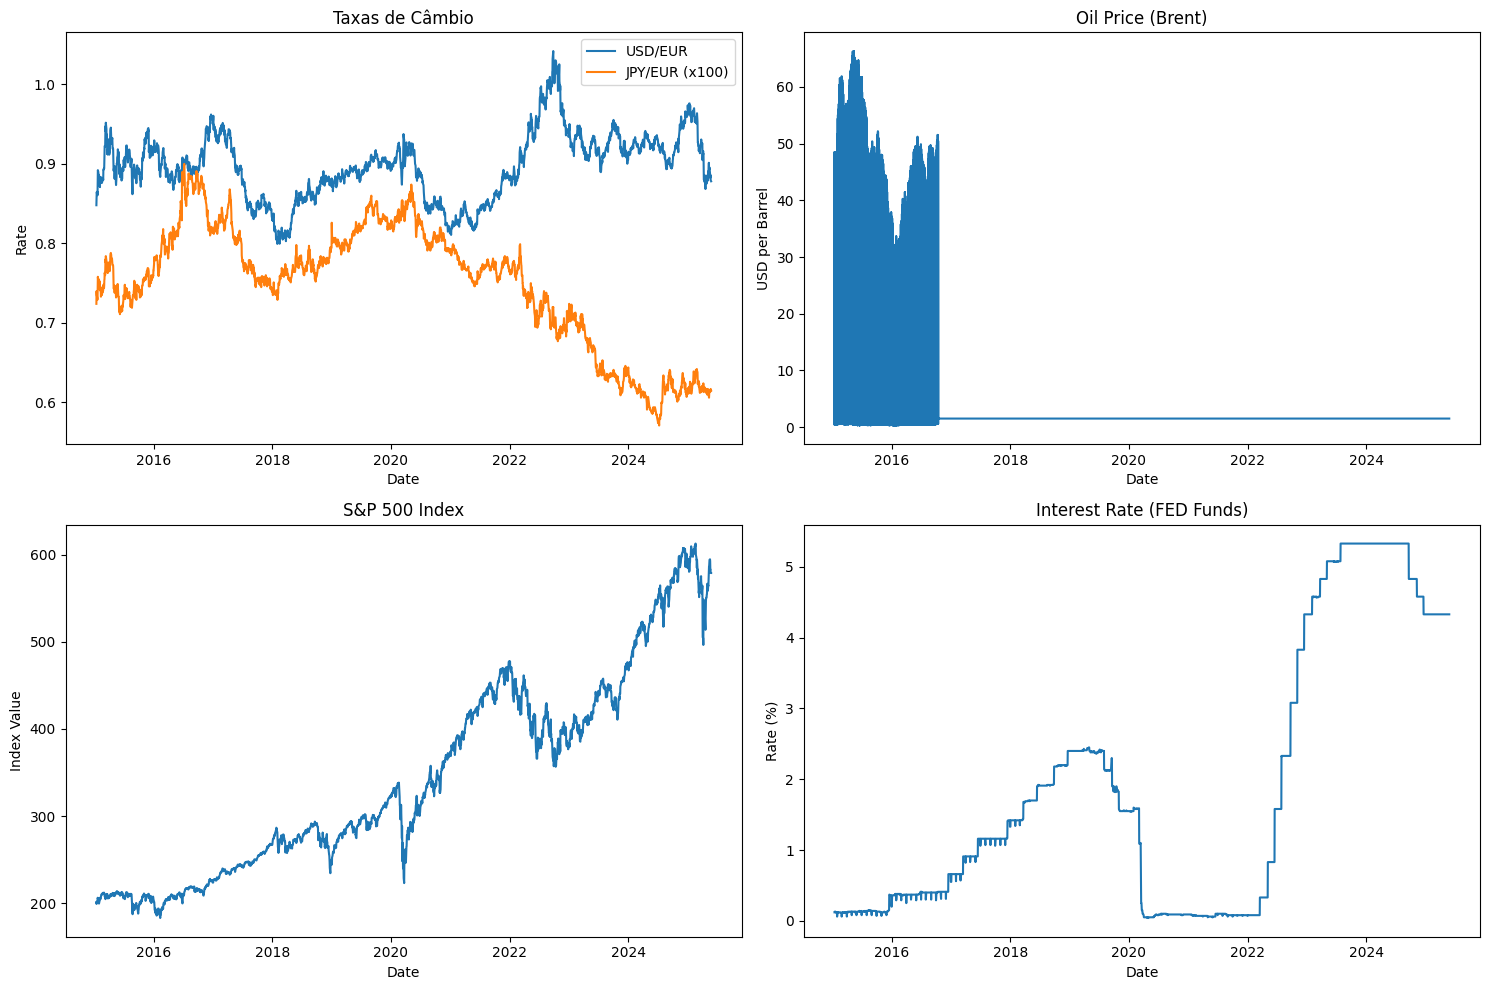

In [4]:


# Plotar visualizações
plt.figure(figsize=(15, 10))

# Taxas de câmbio
plt.subplot(2, 2, 1)
plt.plot(df_final['date'], df_final['exchange_rate_USD_EUR'], label='USD/EUR')
plt.plot(df_final['date'], df_final['exchange_rate_JPY_EUR']*100, label='JPY/EUR (x100)')
plt.title('Taxas de Câmbio')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Preço do petróleo
plt.subplot(2, 2, 2)
plt.plot(df_final['date'], df_final['oil_price'])
plt.title('Oil Price (Brent)')
plt.xlabel('Date')
plt.ylabel('USD per Barrel')

# S&P 500
plt.subplot(2, 2, 3)
plt.plot(df_final['date'], df_final['sp500'])
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Index Value')

# Taxa de juros
plt.subplot(2, 2, 4)
plt.plot(df_final['date'], df_final['interest_rate'])
plt.title('Interest Rate (FED Funds)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')

plt.tight_layout()
plt.show()